# Why does bootstrap still produce inflation

Test old memento see what it does

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
# from pybedtools import BedTool
import pickle as pkl
from statsmodels.stats.multitest import fdrcorrection

%matplotlib inline

In [8]:
import sys
sys.path.append('/home/ubuntu/Github/memento')
# sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
# import encode
import memento.model.rna as rna
import memento.estimator.hypergeometric as hg
import memento.util as util

ModuleNotFoundError: No module named 'memento.estimator.hypergeometric'

In [9]:
data_path = '/data_volume/memento/simulation/'

### Debug memento

In [10]:
adata = sc.read(data_path + 'de/anndata.h5ad')
adata.obs['q'] = 0.1

rna.MementoRNA.setup_anndata(
        adata=adata,
        q_column='q',
        label_columns=['group', 'condition'],
        num_bins=30,
        trim_percent=0.1,
        shrinkage=0.5)

adata = adata[:, adata.X.mean(axis=0).A1 > 0.1]
# model = rna.MementoRNA(adata=adata)

# model.compute_estimate(
#     estimand='mean',
#     get_se=True,
#     n_jobs=30,
# )


/home/ubuntu/anaconda3/envs/mementocxg/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/data_volume/memento/simulation/de/anndata.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
genes = adata.var.index.tolist()

In [ ]:
ctrl_ind1_cells_all = adata[adata.uns['memento']['group_barcodes']['memento_group^A^ctrl']].X.toarray()
stim_ind1_cells_all = adata[adata.uns['memento']['group_barcodes']['memento_group^A^stim']].X.toarray()
ctrl_ind2_cells_all = adata[adata.uns['memento']['group_barcodes']['memento_group^B^ctrl']].X.toarray()
stim_ind2_cells_all = adata[adata.uns['memento']['group_barcodes']['memento_group^B^stim']].X.toarray()

n1 = ctrl_ind1_cells_all.shape[0]
n2 = ctrl_ind2_cells_all.shape[0]

n_list = np.array([n1, n1, n2, n2])

ctrl_ind1_cells_all = ctrl_ind1_cells_all/adata.obs.loc[adata.uns['memento']['group_barcodes']['memento_group^A^ctrl'], 'memento_approx_size_factor'].values.reshape(-1,1)
stim_ind1_cells_all = stim_ind1_cells_all/adata.obs.loc[adata.uns['memento']['group_barcodes']['memento_group^A^stim'], 'memento_approx_size_factor'].values.reshape(-1,1)
ctrl_ind2_cells_all = ctrl_ind2_cells_all/adata.obs.loc[adata.uns['memento']['group_barcodes']['memento_group^B^ctrl'], 'memento_approx_size_factor'].values.reshape(-1,1)
stim_ind2_cells_all = stim_ind2_cells_all/adata.obs.loc[adata.uns['memento']['group_barcodes']['memento_group^B^stim'], 'memento_approx_size_factor'].values.reshape(-1,1)

pv_list = np.zeros(len(genes))
coef_list = np.zeros(len(genes))
for idx, gene in enumerate(genes):

    ctrl_ind1_cells = ctrl_ind1_cells_all[:, idx]
    stim_ind1_cells = stim_ind1_cells_all[:, idx]
    ctrl_ind2_cells = ctrl_ind2_cells_all[:, idx]
    stim_ind2_cells = stim_ind2_cells_all[:, idx]


    m = np.array([
        ctrl_ind1_cells.mean(),
        stim_ind1_cells.mean(),
        ctrl_ind2_cells.mean(),
        stim_ind2_cells.mean()
        
    ])
    lm = np.log(m)
               
    v = np.array([
        ctrl_ind1_cells.var()/n1,
        stim_ind1_cells.var()/n1,
        ctrl_ind2_cells.var()/n2,
        stim_ind2_cells.var()/n2
    ])
    se = np.sqrt(v)
    
    vlm = ( (np.log(m+se) - np.log(m-se))/2 )**2
    
    X = np.array([
        [1, -0.5, 0, 0],
        [1, -0.5, -0.5, 1],
        [1, 0.5, 0, 0],
        [1, 0.5, 0.5, 1]
    ])

    try:
        from sklearn.linear_model import LinearRegression
        # fit WLS using sample_weights
        WLS = LinearRegression()
        WLS.fit(X, lm, sample_weight=n_list)
    except:
        pv_list[idx] = np.nan
        continue
    
    diff_mean = WLS.coef_[-1]
    
    W = np.diag(1/vlm)
    beta_var_hat = np.diag(np.linalg.pinv(X.T@W@X))
    se = np.sqrt( beta_var_hat[-1] )
    
    z = diff_mean/se
    pv = stats.norm.sf(np.abs(z))*2

    pv_list[idx] = pv
    coef_list[idx] = diff_mean

In [3]:
result = pd.DataFrame(
    zip(coef_list,pv_list),
    index=genes,
    columns=['coef','pval']).dropna()

result.pval.hist()

result = result.join(adata.var[['is_de']],how='inner')

_, result['fdr'] = fdrcorrection(result['pval'])
result.to_csv(data_path + 'de/memento_wls.csv')

check_thresh = 0.05
tpr = (result.query('is_de')['pval'] < check_thresh).mean()
fpr = (result.query('~is_de')['pval'] < check_thresh).mean()

print(f'memento successful, fpr = {fpr}, tpr = {tpr}')

NameError: name 'coef_list' is not defined

In [4]:
ctrl_ind1_cells = adata[adata.uns['memento']['group_barcodes']['memento_group^zvgph^ctrl']].X.toarray()
stim_ind1_cells = adata[adata.uns['memento']['group_barcodes']['memento_group^zvgph^stim']].X.toarray()
ctrl_ind2_cells = adata[adata.uns['memento']['group_barcodes']['memento_group^vxkxt^ctrl']].X.toarray()
stim_ind2_cells = adata[adata.uns['memento']['group_barcodes']['memento_group^vxkxt^stim']].X.toarray()

NameError: name 'adata' is not defined

In [90]:
ctrl_ind1_cells = ctrl_ind1_cells/ctrl_ind1_cells.sum(axis=1).reshape(-1,1)
stim_ind1_cells = stim_ind1_cells/stim_ind1_cells.sum(axis=1).reshape(-1,1)
ctrl_ind2_cells = ctrl_ind2_cells/ctrl_ind2_cells.sum(axis=1).reshape(-1,1)
stim_ind2_cells = stim_ind2_cells/stim_ind2_cells.sum(axis=1).reshape(-1,1)

In [ ]:
m = np.array([
    ctrl_ind1_cells.mean(),
    stim_ind1_cells.mean(),
    ctrl_ind2_cells.mean(),
    stim_ind2_cells.mean()
    
])
lm = np.log(m)
           
v = np.array([
    ctrl_ind1_cells.var()/n1,
    stim_ind1_cells.var()/n1,
    ctrl_ind2_cells.var()/n2,
    stim_ind2_cells.var()/n2
])
se = np.sqrt(v)

vlm = ( (np.log(m+se) - np.log(m-se))/2 )**2

X = np.array([
    [1, -0.5, 0, 0],
    [1, -0.5, -0.5, 1],
    [1, 0.5, 0, 0],
    [1, 0.5, 0.5, 1]
])

In [64]:
for idx, gene in enumerate(genes):

    lm = model.estimates['log_mean'][gene].values
    vlm = model.estimates['se_log_mean'][gene].values**2
    X = np.array([
        [1, -0.5, 0, 0],
        [1, -0.5, -0.5, 1],
        [1, 0.5, 0, 0],
        [1, 0.5, 0.5, 1]
    ])
    try:
        from sklearn.linear_model import LinearRegression
        # fit WLS using sample_weights
        WLS = LinearRegression()
        WLS.fit(X, lm, sample_weight=n_list)
    except:
        pv_list[idx] = np.nan
        continue
    
    diff_mean = WLS.coef_[-1]
    
    W = np.diag(1/vlm)
    beta_var_hat = np.diag(np.linalg.pinv(X.T@W@X))
    se = np.sqrt( beta_var_hat[-1] )
    
    z = diff_mean/se
    pv = stats.norm.sf(np.abs(z))*2

    pv_list[idx] = pv

    break

In [ ]:
ctrl_ind1_cells = stats.nbinom.rvs(*convert_params_nb(ctrl_ind1, 0.1), size=n1)
stim_ind1_cells = stats.nbinom.rvs(*convert_params_nb(stim_ind1, 0.1), size=n1)

ctrl_ind2_cells = stats.nbinom.rvs(*convert_params_nb(ctrl_ind2, 0.1), size=n2)
stim_ind2_cells = stats.nbinom.rvs(*convert_params_nb(stim_ind2, 0.1), size=n2)

In [71]:
adata[adata.obs['group']

View of AnnData object with n_obs × n_vars = 600 × 12481
    obs: 'group', 'condition', 'q', 'memento_group', 'memento_size_factor', 'memento_approx_size_factor'
    var: 'is_de', 'treatment_effect'
    uns: 'memento'

In [37]:
results = pd.DataFrame(
    pv_list,
    index=genes,
    columns=['pval']).dropna()


array([[<Axes: title={'center': 'pval'}>]], dtype=object)

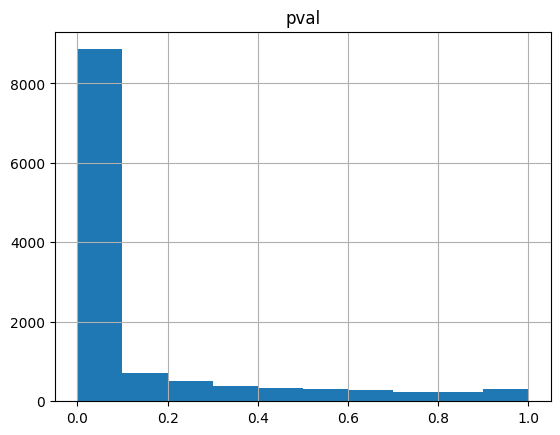

In [39]:
results.hist()

In [26]:
pv

0.0002948183512864257

In [7]:
gene_idx = 0

lm = model.estimates['log_mean'].iloc[:, gene_idx]

vlm = model.estimates['se_log_mean'].iloc[:, gene_idx]**2

X = np.array([
    [1, -0.5, 0, 0],
    [1, -0.5, -0.5, 1],
    [1, 0.5, 0, 0],
    [1, 0.5, 0.5, 1]
    ])

from sklearn.linear_model import LinearRegression

WLS = LinearRegression()
WLS.fit(X, lm, sample_weight=n_list)

diff_mean = WLS.coef_[-1]

W = np.diag(1/vlm)
beta_var_hat = np.diag(np.linalg.pinv(X.T@W@X))
se = np.sqrt( beta_var_hat[-1] )

z = diff_mean/se
pv = stats.norm.sf(np.abs(z))*2

NameError: name 'n_list' is not defined

In [275]:



def run_memento(adata):
    memento.setup_memento(adata, q_column='q', trim_percent=1, shrinkage=0)
    stim_converter={'ctrl':0, 'stim':1}
    adata.obs['stim_indicator'] = adata.obs['condition'].apply(lambda x: stim_converter[x])
    
    memento.create_groups(adata, label_columns=['group', 'condition'])
    memento.compute_1d_moments(adata, min_perc_group=.5)
    print(adata.shape)

    df = pd.DataFrame(index=adata.uns['memento']['groups'])
    df['group'] = df.index.str.split('^').str[1]
    df['condition'] = df.index.str.split('^').str[2]

    cov_df = pd.get_dummies(df[['group']], drop_first=True).astype(float)
    cov_df -= cov_df.mean()
    stim_df = (df[['condition']]=='stim').astype(float)
    interaction_df = cov_df*stim_df[['condition']].values
    interaction_df.columns=[f'interaction_{col}' for col in cov_df.columns]
    cov_df = pd.concat([cov_df, interaction_df], axis=1)
    # cov_df = sm.add_constant(cov_df)
    # cov_df = cov_df.iloc[:, [0]]

    # print(cov_df)
    stim_df = (df[['condition']]=='stim').astype(float)

    memento.ht_1d_moments(
        adata, 
        treatment=stim_df,
        covariate=cov_df, 
        num_boot=10000, 
        verbose=1,
        num_cpus=30,
        approx=True)
    
    return memento.get_1d_ht_result(adata).set_index('gene').join(adata.var)


In [276]:
df = run_memento(adata)

(550, 6068)


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 220 tasks      | elapsed:    1.1s
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.10.egg/memento/hypothesis_test.py:236: RuntimeWarning: invalid value encountered in divide
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:411: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:416: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 f

In [277]:
# groups = adata.obs['group'].unique()

In [278]:
# results = []
# for group in groups:
    
#     subset = adata[adata.obs['group'] == group].copy()
    
#     results.append(run_memento(subset))

# import functools

# common_genes = functools.reduce(lambda x,y: list(set(x) & set(y)), [res.index for res in results])



# effect_size = np.vstack([res.loc[common_genes, 'de_coef'].values for res in results])
# var = np.vstack([res.loc[common_genes, 'de_se'].values**2 for res in results])

# ATE = np.average(effect_size, axis=0, weights=1/var)
# SE = np.sqrt(1/(1/var).sum(axis=0))
# Z = ATE/SE
# P = 2*stats.norm.sf(np.absolute(Z))

# df = pd.DataFrame(
#     zip(ATE, SE, Z, P),
#     columns=['coef', 'se', 'z', 'de_pval'], 
#     index=common_genes).join(adata.var)

In [279]:
df['fdr'] = memento.util._fdrcorrect(df['de_pval'])
df['pval'] = df['de_pval']

In [280]:
df.to_csv(data_path + 'old_memento.csv')

In [281]:
# df= memento.get_1d_ht_result(adata).set_index('gene').join(adata.var)
# df['fdr'] = memento.util._fdrcorrect(df['de_pval'])


(605, 12)
(607, 12)


Text(0.5, 1.0, 'Highly expressed')

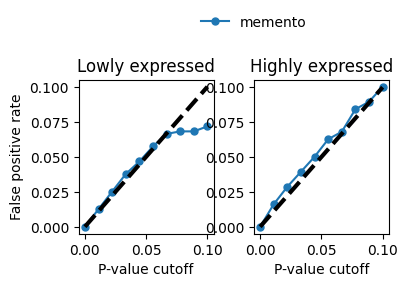

In [282]:
results = {'memento':df}
n=10

means = pd.DataFrame(adata.X.mean(axis=0).A1, index=adata.var.index)
means.columns=['mean']
plt.figure(figsize=(4,2))
plt.subplots_adjust(wspace=0.3)

# LOW EXPR genes
plt.subplot(1, 2, 1);
sig_thresholds = np.linspace(0, 0.1, n)

for method, result in results.items():
    result = result.join(means)
    result = result.loc[result['mean'] < np.quantile(result['mean'], 0.1)]
    print(result.shape)
    
    fdr = []
    fpr = []
    
    sorted_result = result.sort_values('fdr')
    for thresh in sig_thresholds:

        fdr_hits = result.query(f'fdr < {thresh}')
        fpr_hits = result.query(f'pval < {thresh}')
        fdr.append(1-fdr_hits['is_de'].mean())
        fpr.append((result.query('~is_de')['pval'] < thresh).mean())
    plt.plot(sig_thresholds, fpr, '-o', label=method, markersize=5)
plt.ylabel('False positive rate')
plt.plot([0, 0.1], [0, 0.1], '--', color='k', lw=3)
plt.xlabel('P-value cutoff')
plt.title('Lowly expressed')

# HIGH EXPR genes
plt.subplot(1, 2, 2)
for method, result in results.items():
    result = result.join(means)
    result = result.loc[result['mean'] > np.quantile(result['mean'], 0.9)]
    print(result.shape)

    fdr = []
    fpr = []
    
    sorted_result = result.sort_values('fdr')
    for thresh in sig_thresholds:

        fdr_hits = result.query(f'fdr < {thresh}')
        fpr_hits = result.query(f'pval < {thresh}')
        fdr.append(1-fdr_hits['is_de'].mean())
        fpr.append((result.query('~is_de')['pval'] < thresh).mean())
    plt.plot(sig_thresholds, fpr, '-o', label=method, markersize=5)
    plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(0, 1.5), ncol=2)
plt.plot([0, 0.1], [0, 0.1], '--', color='k', lw=3)
plt.xlabel('P-value cutoff')
plt.title('Highly expressed')
